
# pPXF: Fitting integral-field data at high redshift

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

### MODIFICATION HISTORY

* V1.0.0: Michele Cappellari, Oxford, 7 June 2024

___

In [1]:
from pathlib import Path
from urllib import request

import numpy as np
from astropy.io import fits
from scipy import signal, ndimage
import matplotlib.pyplot as plt

from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.plot_velfield import plot_velfield
from plotbin.display_pixels import display_pixels

## Function to read the MUSE cube

In [2]:
class read_data_cube:
    def __init__(self, filename, wave_range, redshift, sn_min=1):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cuberr = self.cuberr[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cuberr, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize
        y = (row - row[jm])*self.pixsize

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)    # create array of spectra [npix, nx*ny]
        variance = cuberr.reshape(npix, -1) # create array of spectra [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        good = select_galay_spaxels(signal/noise, sn_min)

        # Coordinates and signal for all spaxels of original cube (for plotting)
        self.signal_all = signal.ravel()
        self.x_all = x   
        self.y_all = y

        # Coordinates and spectra only for spaxels with enough signal
        self.good = good    
        self.spectra = spectra[:, good]  
        self.variance = variance[:, good]
        self.x = x[good] 
        self.y = y[good]
        self.signal = signal.flat[good]
        self.noise = noise.flat[good]

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)  

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """
        hdu = fits.open(filename)
        head = hdu["data"].header
        cube = hdu["data"].data  
        cuberr = hdu["stat"].data 

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0])

        self.cube = cube
        self.cuberr = cuberr
        self.wave = wave
        self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.pixsize = abs(head["CD2_2"])*3600    # 0.2"

###############################################################################

def select_galay_spaxels(sn, sn_min):
    """Return indices of the largest blob of connected spaxels with S/N > sn_min"""

    mask = signal.medfilt(sn, 3) > sn_min
    labels, nb = ndimage.label(mask)                    # Get blob indices
    j = np.argmax(np.bincount(labels.flat)[1:]) + 1     # Index of largest blob
    
    return np.flatnonzero(labels == j)

## Function to iteratively clip the outliers

In [3]:
def clip_outliers(galaxy, bestfit, mask):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma in relative
    error until the bad bins don't change any more. This function uses eq.(34)
    of Cappellari (2023) https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C
    """
    while True:
        scale = galaxy[mask] @ bestfit[mask]/np.sum(bestfit[mask]**2)  
        resid = scale*bestfit[mask] - galaxy[mask]
        err = robust_sigma(resid, zero=1)
        ok_old = mask
        mask = np.abs(bestfit - galaxy) < 3*err
        if np.array_equal(mask, ok_old):
            break
            
    return mask

## Function to fit the stellar kinematics

In [4]:
def ppxf_fit_and_clean(templates, galaxy, velscale, start, mask0, lam, lam_temp, plot=True, quiet=False):
    """
    This is a simple pPXF wrapper. It perform two pPXF fits: the first one
    serves to estimate the scatter in the spectrum and identify the outlier
    pixels. The second fit uses the mask obtained from the first fit to exclude
    the outliers. The general approach used in this function is described in
    Sec.6.5 of Cappellari (2023) https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C
    """
    mask = mask0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=4, mdegree=-1, lam=lam, lam_temp=lam_temp,
              mask=mask, quiet=quiet)

    if plot:
        plt.figure(figsize=(20, 3))
        plt.subplot(121)
        pp.plot()
        plt.title("Initial pPXF fit before outliers removal")

    mask = clip_outliers(galaxy, pp.bestfit, mask)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    mask &= mask0
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=4, mdegree=-1, lam=lam, lam_temp=lam_temp,
              mask=mask, quiet=quiet)
    
    optimal_template = templates.reshape(templates.shape[0], -1) @ pp.weights
    
    resid = (pp.galaxy - pp.bestfit)[pp.goodpixels]
    sn = np.nanmedian(pp.galaxy[pp.goodpixels])/robust_sigma(resid)

    if plot:
        plt.subplot(122)
        pp.plot()

    return pp, optimal_template, sn

## Data input and Voronoi binning

Load the MUSE data cube

In [5]:
lam_range_temp = [3540, 5500]   
redshift = 0.43     # Initial redshift estimate
sn_min = 0.5        # This is to remove residuals-dominated spectra before Voronoi binning

Read the input data. If the data file does not exists, download it from my GitHub page.

In [6]:
objfile = Path('MACS1206_7876.fits')  
if not objfile.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_examples/main/" + objfile.name
    request.urlretrieve(url, objfile)

s = read_data_cube(objfile, lam_range_temp, redshift)

Spatially Voronoi bin the data to a target $S/N=5$ per bin using the [VorBin](https://pypi.org/project/vorbin/) method and software of [Cappellari & Copin (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.342..345C/abstract)

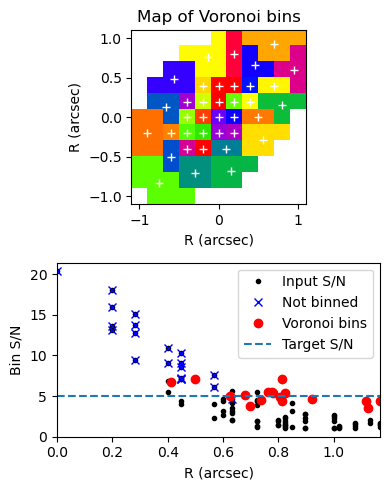

In [7]:
plt.figure(figsize=(4, 5))
target_sn = 5 
bin_num = voronoi_2d_binning(s.x, s.y, s.signal, s.noise, target_sn, plot=1, quiet=1)[0]
plt.tight_layout()

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for
four SPS. One can just uncomment one of the four models below. The
included files are only a subset of the SPS that can be produced with the
models, and one should use the relevant software/website to produce
different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [8]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

sps = lib.sps_lib(filename, s.velscale, s.fwhm_gal)
stars_templates = sps.templates

## pPXF Fit to global spectrum

In [9]:
start = [0, 200.]  # (km/s), starting guess for [V,sigma]
mask0 = s.ln_lam_gal > 0    # Do not use an initial mask in this case. This could be used to mask known emission lines
lam_gal = np.exp(s.ln_lam_gal)

If `single_template` is set to `True`, a single template is created using the average global spectrum of the galaxy. This single template is then employed to fit the kinematics across all Voronoi bins. On the other hand, if `single_template` is set to `False`, the entire library of SPS templates is fitted to each Voronoi bin individually. Opting for a single optimal template is generally more robust for data with low signal-to-noise ratios ($S/N$), but it can introduce bias when there are very strong population gradients. Although, in most scenarios, the results should not differ significantly between the two approaches.

 Best Fit:       Vel     sigma
 comp.  0:        14       189
chi2/DOF: 1.054; DOF: 2769; degree = 4; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
 Best Fit:       Vel     sigma
 comp.  0:         9       186
chi2/DOF: 0.3476; DOF: 2710; degree = 4; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Global spectrum; $\sigma$=186 km/s; S/N=33.8
##############################################################################


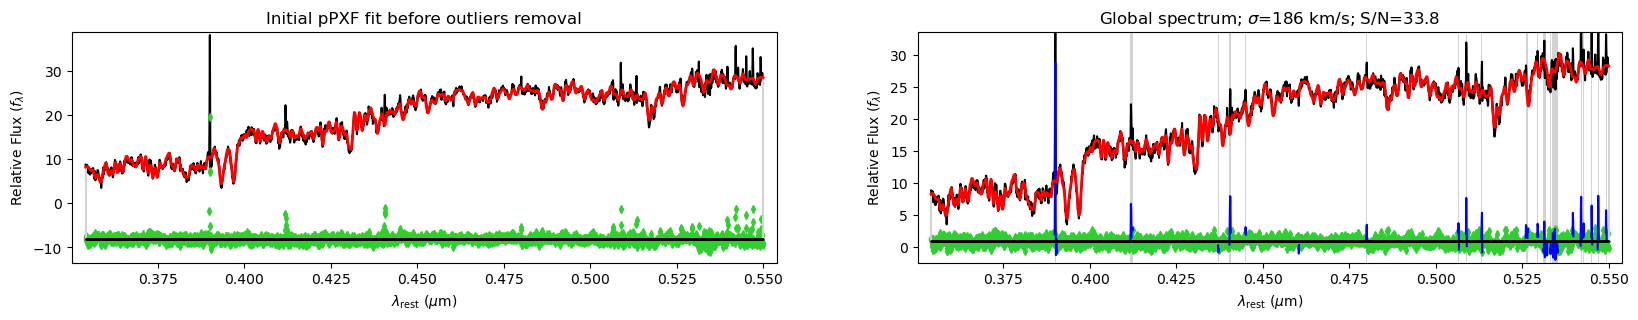

In [10]:
single_template = True
if single_template:
    galaxy = np.nanmean(s.spectra[:, s.signal/s.noise > 5], 1)   # Global spectrum
    pp, optimal_template, sn = ppxf_fit_and_clean(
            stars_templates, galaxy, s.velscale, start, mask0, lam_gal, sps.lam_temp)
    txt = f"Global spectrum; $\\sigma$={pp.sol[1]:.0f} km/s; S/N={sn:.1f}"
    print(txt + '\n' + '#'*78)
    plt.title(txt)
else:
    optimal_template = stars_templates

## pPXF fit to all Voronoi bins

Fit the kinematics of all Voronoi bins. Also store the centroid of the Voronoi bins for plotting.

 Best Fit:       Vel     sigma
 comp.  0:        30       196
chi2/DOF: 6.319; DOF: 2769; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/1
Templates weights:
      2.21
 Best Fit:       Vel     sigma
 comp.  0:        31       197
chi2/DOF: 5.131; DOF: 2742; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/1
Templates weights:
      2.22
Voronoi bin 1 / 37; $\sigma$=197 km/s; S/N=18.9
##############################################################################
 Best Fit:       Vel     sigma
 comp.  0:        51       151
chi2/DOF: 5.025; DOF: 2769; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/1
Templates weights:
      1.23
 Best Fit:       Vel     sigma
 comp.  0:        48       150
chi2/DOF: 4.024; DOF: 2730; degree = 4; 

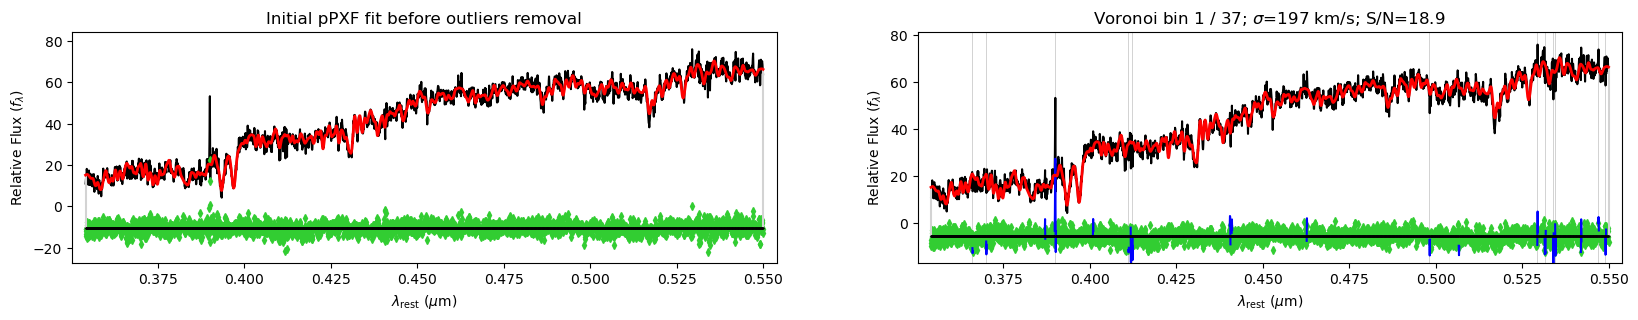

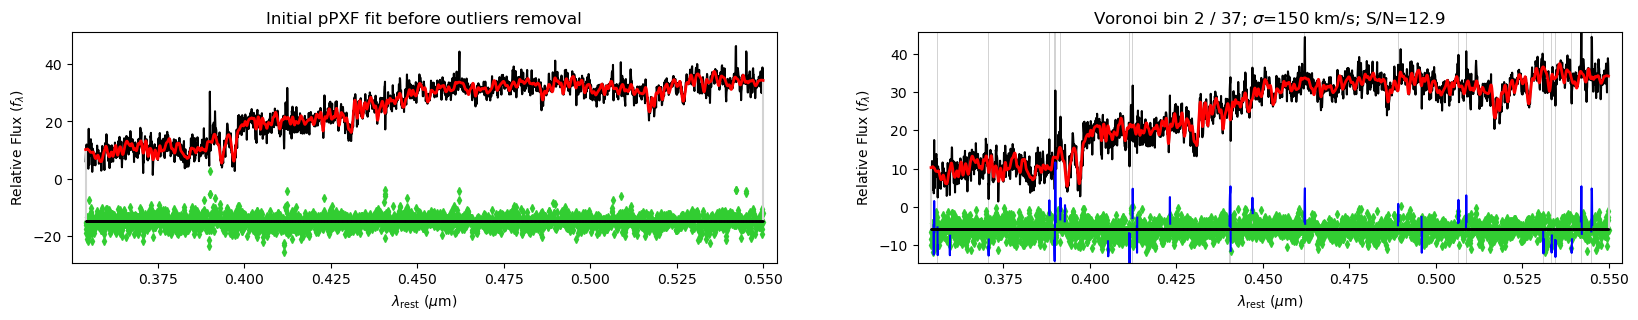

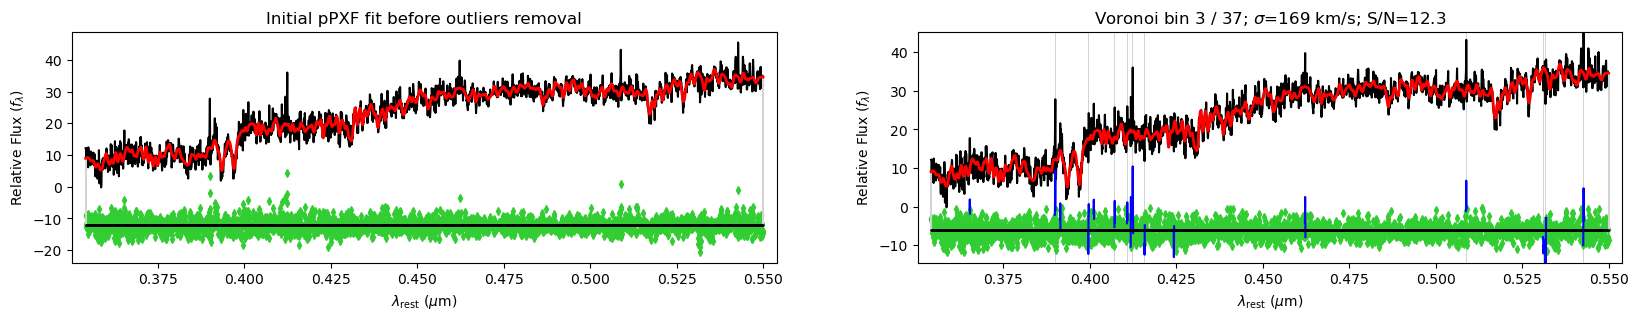

In [11]:

nbins = np.unique(bin_num).size
velbin, sigbin, xbin, ybin = np.zeros((4, nbins))

for j in range(nbins):
    plot = True if j < 3 else False  # Only plot the first few spectra
    w = bin_num == j
    galaxy = np.nanmean(s.spectra[:, w], 1)
    pp, _, sn = ppxf_fit_and_clean(
        optimal_template, galaxy, s.velscale, start, mask0, lam_gal, sps.lam_temp, plot=plot, quiet=not plot)
    velbin[j], sigbin[j] = pp.sol
    xbin[j], ybin[j] = np.mean(s.x[w]), np.mean(s.y[w])

    if plot:
        txt = f"Voronoi bin {j + 1} / {nbins}; $\\sigma$={sigbin[j]:.0f} km/s; S/N={sn:.1f}"
        print(txt + '\n' + '#'*78)
        plt.title(txt)

Plot the output kinematics maps

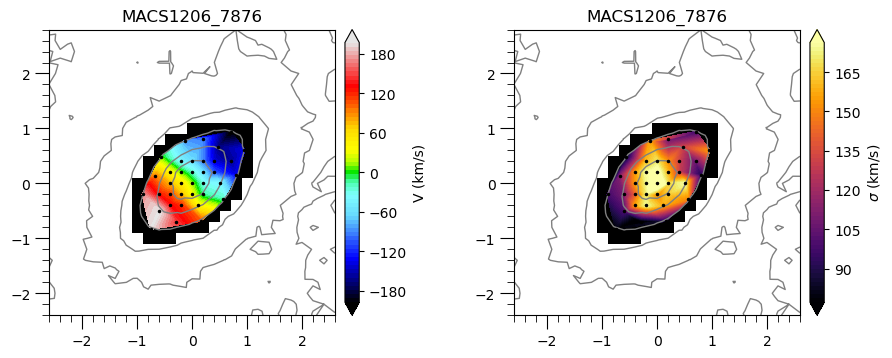

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
velbin -= np.median(velbin)
vmax = np.percentile(abs(velbin), 95)
mag = -2.5*np.log10(s.signal_all/np.max(s.signal_all))
plt.tricontour(s.x_all, s.y_all, mag, levels=np.arange(20), linewidths=1, colors='gray');  # 1 mag contours
plot_velfield(xbin, ybin, velbin, colorbar=1, cmap='sauron', label='V (km/s)', vmin=-vmax, vmax=vmax)
display_pixels(s.x, s.y, np.zeros_like(s.x), cmap='gray')
plt.title(objfile.stem)

plt.subplot(122)
vmin, vmax = np.percentile(sigbin, [5, 95])
plt.tricontour(s.x_all, s.y_all, mag, levels=np.arange(20), linewidths=1, colors='gray');  # 1 mag contours
plot_velfield(xbin, ybin, sigbin, colorbar=1, cmap='inferno', label=r'$\sigma$ (km/s)', vmin=vmin, vmax=vmax)
display_pixels(s.x, s.y, np.zeros_like(s.x), cmap='gray')
plt.title(objfile.stem)
plt.pause(5);